In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

df = pd.read_csv('income.csv')

# Check the length and preview of the dataframe
print(f"Length of the dataset: {len(df)}")
print("First 5 rows of the dataset:")
print(df.head())


Length of the dataset: 30000
First 5 rows of the dataset:
   age     sex    education  education-num marital-status    workclass  \
0   27    Male      HS-grad              9  Never-married      Private   
1   47    Male      Masters             14        Married    Local-gov   
2   59    Male      HS-grad              9       Divorced     Self-emp   
3   38  Female  Prof-school             15  Never-married  Federal-gov   
4   64  Female         11th              7        Widowed      Private   

        occupation  hours-per-week income  label  
0     Craft-repair              40  <=50K      0  
1  Exec-managerial              50   >50K      1  
2   Prof-specialty              20  <=50K      0  
3   Prof-specialty              57   >50K      1  
4  Farming-fishing              40  <=50K      0  


In [4]:
# Define categorical and continuous columns
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

# Print out column counts
print(f'cat_cols has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col has {len(y_col)} column')

cat_cols has 5 columns
cont_cols has 2 columns
y_col has 1 column


In [5]:
# Convert categorical columns to category type
for col in cat_cols:
    df[col] = df[col].astype('category')

# Shuffle the data
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)

# Preview the first 5 rows of the shuffled dataset
print(df.head())


   age     sex     education  education-num marital-status  workclass  \
0   23  Female       HS-grad              9  Never-married    Private   
1   37  Female   Prof-school             15        Married  State-gov   
2   34    Male  Some-college             10       Divorced    Private   
3   31    Male       HS-grad              9        Married    Private   
4   20  Female  Some-college             10  Never-married    Private   

       occupation  hours-per-week income  label  
0   Other-service              50  <=50K      0  
1  Prof-specialty              39   >50K      1  
2    Adm-clerical              40  <=50K      0  
3    Craft-repair              40   >50K      1  
4           Sales              25  <=50K      0  


In [6]:
# Create embedding sizes for each categorical column
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
print(f"Embedding sizes: {emb_szs}")

# Convert categorical data to numeric codes
cats = torch.tensor(np.stack([df[col].cat.codes.values for col in cat_cols], axis=1), dtype=torch.long)

# Convert continuous data to tensors
conts = torch.tensor(np.stack([df[col].values for col in cont_cols], axis=1), dtype=torch.float32)

# Convert labels to tensor
y = torch.tensor(df[y_col].values).flatten()

# Split data into training and test sets
b = 30000  # batch size
t = 5000   # test size

cat_train = cats[:b-t]
cat_test  = cats[b-t:b]
con_train = conts[:b-t]
con_test  = conts[b-t:b]
y_train   = y[:b-t]
y_test    = y[b-t:b]

print(f"cat_train shape: {cat_train.shape}")
print(f"con_train shape: {con_train.shape}")
print(f"y_train shape: {y_train.shape}")

Embedding sizes: [(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]
cat_train shape: torch.Size([25000, 5])
con_train shape: torch.Size([25000, 2])
y_train shape: torch.Size([25000])


In [7]:
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        
        # Create embedding layers for categorical columns
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        
        # Dropout for embeddings and batch normalization for continuous columns
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        # Build hidden layers
        layerlist = []
        n_emb = sum((nf for ni, nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1], out_sz))
        
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        # Process categorical data through embedding layers
        embeddings = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        # Process continuous data through batch normalization
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)

        # Pass through the hidden layers
        x = self.layers(x)
        return x

In [8]:
# Initialize the model, loss function, and optimizer
torch.manual_seed(33)
model = TabularModel(emb_szs, n_cont=len(cont_cols), out_sz=2, layers=[50], p=0.4)

# Use CrossEntropyLoss for classification and Adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)


Epoch   1 Loss: 0.81344736
Epoch  26 Loss: 0.59463936
Epoch  51 Loss: 0.51533055
Epoch  76 Loss: 0.46403277
Epoch 101 Loss: 0.42922780
Epoch 126 Loss: 0.40061691
Epoch 151 Loss: 0.37124613
Epoch 176 Loss: 0.35843733
Epoch 201 Loss: 0.34799820
Epoch 226 Loss: 0.33588532
Epoch 251 Loss: 0.33127117
Epoch 276 Loss: 0.32283258


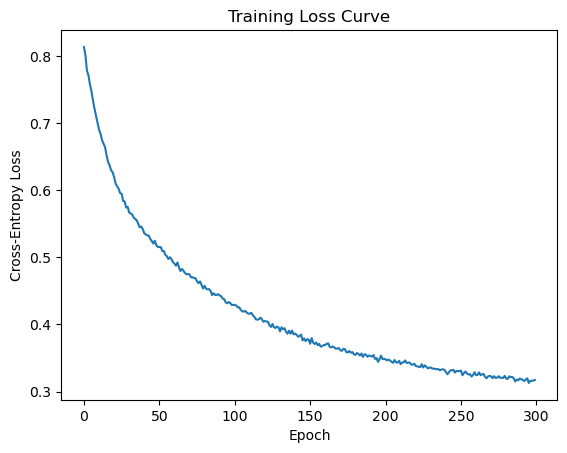

In [9]:
# Training loop
epochs = 300
losses = []

for i in range(1, epochs + 1):
    # Forward pass
    y_pred = model(cat_train, con_train)
    
    # Compute loss
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    # Print loss every 25 epochs
    if i % 25 == 1:
        print(f'Epoch {i:3} Loss: {loss.item():.8f}')
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss Curve')
plt.show()